# T1 de NoIA

Neste trabalho, vamos aprender a implementar o algoritmo de redes neurais de aprendizado de máquina (ANN) para a tarefa de classificação de imagens de maneira mais eficiente. Vamos passar pelas várias técnicas de implementação que foram utilizadas ao longo do desenvolvimento e a evolução da tecnologia.

## Importações

Neste trabalho, utilizaremos a biblioteca [d2l](https://github.com/d2l-ai/d2l-en) para implementar o algoritmo de redes neurais. A biblioteca d2l é uma biblioteca de aprendizado de máquina de alto nível, desenvolvida pela DeepMind. Ela fornece uma interface amigável para a implementação de modelos de redes neurais, incluindo o uso de GPUs para acelerar o processo de treinamento.
Nos também utilizaremos a biblioteca tensorflow para fornecer as funções de redes neurais, matplotlib para visualizar os resultados, sklearn para realizar o treinamento e validação dos modelos, e pdb para depurar o código.

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import statistics

## Base de dados

A base de dados é um conjunto de dados de treinamento e teste que serão utilizados para treinar e avaliar o modelo. Neste caso, vamos utilizar o conjunto de dados de teste do MNIST, que é um conjunto de imagens de tamanho 28x28 e de número de classes 10.

In [2]:
class MNIST(d2l.DataModule): #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()

In [3]:
data = MNIST()
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


Para podermos usar o d2l para o treinamento temos que definir o dataloader que divide o dataset em batchs e o modelo que irá receber os dados e fazer a predição.

In [4]:
@d2l.add_to_class(MNIST) #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255, tf.cast(y, dtype='int32'))
    self.resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(self.batch_size).shuffle(shuffle_buf)

@d2l.add_to_class(MNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(tf.squeeze(X), nrows, ncols, titles=labels)

In [5]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

2024-12-03 13:51:10.077402: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


## Modelo básico perceptron

Aqui definimos a nossa primeira versão do modelo perceptron. O modelo perceptron é um modelo de classificação simples que é capaz de classificar dados de entrada em uma classe de saída. Neste caso é um modelo bem simples, com uma camada que transforma a matrix da entrada em um vetor (flatten), uma camada oculta e uma camada de saída, ambas usando a função sigmoide.

In [6]:
class MLPSigmoid(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='sigmoid')])
        self.loss_fn=tf.keras.losses.MeanSquaredError
        self.optimizer=tf.keras.optimizers.SGD

Para podermos ter resultados o mais precisos, vamos realizar o treino 5 vezes e usar a média dos resultados para definirmos o erro médio do modelo usado.

0.9038


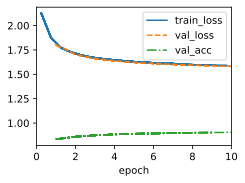

In [7]:
sigmoid_model = MLPSigmoid(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(sigmoid_model, data)
print(d2l.evaluate_accuracy(sigmoid_model, data.val_dataloader()))

## Perceptron com saída softmax

O nosso próximo modelo será um perceptron com uma saída softmax. Como mudamos a saída para o resultado esperado, e não uma saída "one-hot", também mudamos o erro para o modelo de entropia cruzada.

In [8]:
class MLPSoftMax(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.SGD

Novamente, vamos rodar o modelo 5 vezes para conseguirmos a acurácia média.

0.7581


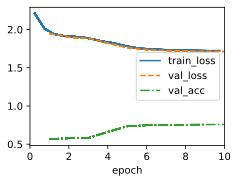

In [9]:
soft_model = MLPSoftMax(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(soft_model, data)
print(d2l.evaluate_accuracy(soft_model, data.val_dataloader()))

## Otimizador Adam

Com o desenvolvimento dos modelos de machine learning, diferentes propostas de otimizadores de gradiente foram desenvolvidas. Uma das mais famosas é o otimizador Adam, que é uma extensão do otimizador SGD (Stochastic Gradient Descent). O SGD é um otimizador de gradiente que atualiza os pesos da rede de forma a minimizar a função de perda. O Adam é um otimizador que atualiza os pesos da rede de forma a minimizar a função de perda, mas com uma variação na atualização dos pesos.

In [10]:
class MLPAdam(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

Novamente, para certificar a acurácia do modelo, vamos treiná-lo 5 vezes, e calcular a média de acurácia.

0.8203


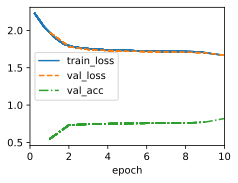

In [11]:
adam_model = MLPAdam(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(adam_model, data)
print(d2l.evaluate_accuracy(adam_model, data.val_dataloader()))

## Função Relu

Um desenvolvimento inesperado, mas que é muito interessante, é a função relu. A função relu é uma função que recebe um valor e retorna o mesmo valor se ele for positivo ou zero se ele for negativo. E ela já da não linearidade o suficiente para ser usada como uma função de ativação.

In [12]:
class MLPRelu(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

0.9452


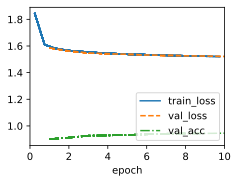

In [13]:

relu_model = MLPRelu(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(relu_model, data)
print(d2l.evaluate_accuracy(relu_model, data.val_dataloader()))

## Rede com 256 neurônios escondidos

Agora que aplicamos vários modelos que diminuem o tempo de treinamento, vamos tentar uma implementação mais eficaz. Vamos usar o modelo MLP com 256 neurônios escondidos.

0.9483


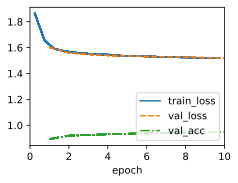

In [14]:

relu_256_model = MLPRelu(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(relu_256_model, data)
print(d2l.evaluate_accuracy(relu_256_model, data.val_dataloader()))

## Rede com 2 camadas escondidas

Além de podermos tornar a camada escondida maior, com o tempo de processamento que poupamos nos também possibilitamos a inserção de múltiplas camadas escondidas.

In [15]:
class MLPRelu2Hidden(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

0.9585


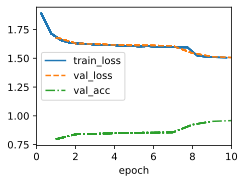

In [16]:

hidden_model = MLPRelu2Hidden(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(hidden_model, data)
print(d2l.evaluate_accuracy(hidden_model, data.val_dataloader()))

# Visualização dos resultados

[<tf.Tensor: shape=(), dtype=int32, numpy=5>, <tf.Tensor: shape=(), dtype=int32, numpy=4>, <tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>, <tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=9>, <tf.Tensor: shape=(), dtype=int32, numpy=7>, <tf.Tensor: shape=(), dtype=int32, numpy=7>]


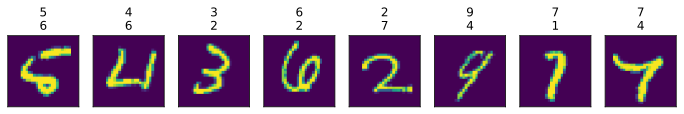

In [ ]:
dados = iter(data.val_dataloader())
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(sigmoid_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

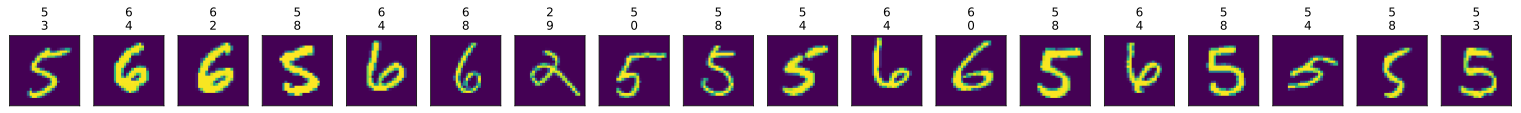

In [39]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(soft_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

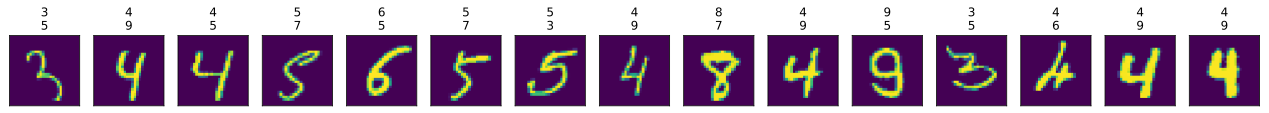

In [40]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(adam_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

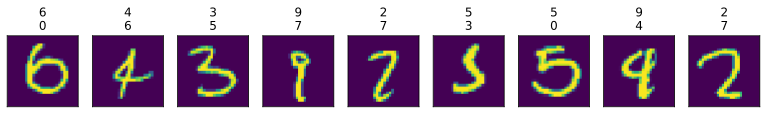

In [41]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(relu_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

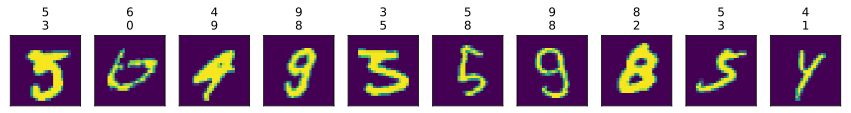

In [42]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(relu_256_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

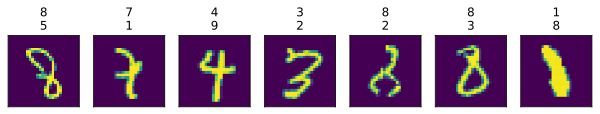

In [43]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(hidden_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

# Matriz de confusão

In [50]:
X,y = data.val
preds=tf.argmax(hidden_model(X),axis=1)
wrong=tf.cast(preds,y.dtype)!=y
confusion_matrix(y,preds)

array([[ 969,    0,    3,    3,    0,    1,    2,    1,    1,    0],
       [   0, 1122,    2,    3,    0,    1,    3,    1,    3,    0],
       [   7,    4,  964,   11,   11,    1,    7,   13,   11,    3],
       [   0,    0,   13,  977,    0,    4,    0,    7,    9,    0],
       [   1,    0,    5,    0,  937,    0,    9,    1,    4,   25],
       [   7,    1,    1,   14,    3,  838,    9,    1,   12,    6],
       [   7,    3,    4,    2,    3,    4,  932,    0,    3,    0],
       [   3,    9,   25,    3,    4,    0,    0,  970,    3,   11],
       [   2,    2,    4,   12,    3,    3,    8,    5,  930,    5],
       [   7,    6,    3,   11,   12,    2,    1,    8,    6,  953]])